In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.time_series_functions import *
# from pandas.plotting import register_matplotlib_converters
# register_matplotlib_converters()

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
keras = tf.keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# from keras.callbacks import EarlyStopping#, ModelCheckpoint
from keras.metrics import MeanAbsolutePercentageError


%matplotlib inline

Using TensorFlow backend.


In [2]:
#load in master df
base_df = csv_with_datetime('data/master_df.csv', 'ds')
df = base_df.copy()
df.drop('Unnamed: 0', axis=1, inplace=True)
df.info(), df.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11323 entries, 1990-01-01 to 2020-12-31
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ds            11323 non-null  datetime64[ns]
 1   y             11323 non-null  float64       
 2   avg_temp      11323 non-null  float64       
 3   precip_accum  11323 non-null  float64       
 4   swe           11323 non-null  float64       
 5   hist_avg_y    11323 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 619.2 KB


(None,
                    ds    y  avg_temp  precip_accum  swe  hist_avg_y
 ds                                                                 
 1990-01-01 1990-01-01  6.5      19.0           5.6  4.8    6.437742
 1990-01-02 1990-01-02  6.9      16.0           5.7  4.8    6.502258
 1990-01-03 1990-01-03  6.9       2.0           5.7  4.8    6.673226)

In [3]:
int('2020')

2020

In [26]:
#functionize to take a year and produce graph, rmse, and lift over historical avg model. 
#function requires a minimum of 6000 samples, set pred_year accordingly
#function designed to work with project-specific column names, edits would be required to work with other data

def year_eval_lstm(model, pred_year, master_df):
    df = master_df.copy()
    
    #making desired year last year in sample data
    samp_df = df[:pred_year]

    #trimming sample data to 6000 records total
    samp_df = samp_df.iloc[-6000:]

    # convert datetime column to continuous integer
    samp_df['ds'] = pd.to_datetime(df['ds']).sub(pd.Timestamp(df['ds'].iloc[0])).dt.days
    
    #don't pass in historical y to model
    samp_df.drop('hist_avg_y', axis=1, inplace=True)
    
    # scale entire dataframe except y column 
    scale_df = samp_df.copy()
    for column in scale_df.columns:
      if column != 'y':
        scaler = StandardScaler()
        # print (scale_df[column].values.shape)
        holder = scaler.fit_transform(scale_df[column].values.reshape(-1,1))
        scale_df[column] = holder.reshape(len(scale_df),)
        
    #test size depends if year is leap year or not
    test_size = 365
    if int(pred_year)%4 == 0:
        test_size = 366
        
    #these variables can't be changed without retraining models used in this project
    n_prev = 400 #model was trained on this input shape
    predict_steps = 30 #model was trained on this output shape
    
    #utilizes windowize_data function
    X, y = windowize_data(scale_df, n_prev, 'y', predict_steps)
    X_test = X[-test_size:]
    y_test = y[-test_size:]
    
    #use model to make predictions and make 0 the lower limit of predictions
    y_pred = model.predict(X_test)
    y_pred[y_pred<0] = 0

    
    #grab predictions at 1-day, 14-days, and 30-days out for each day of the year
    day_1_pred = y_pred[:,:1]          
    day_14_pred = y_pred[:,13:14]
    day_30_pred = y_pred[:,-1:]
    
    #collect and print rmse for 1-day, 14-days, and 30-days prediction sets
    day_1_rmse  = sqrt(mean_squared_error(y_test[:,:1], day_1_pred))
    day_14_rmse = sqrt(mean_squared_error(y_test[:,13:14], day_14_pred))
    day_30_rmse = sqrt(mean_squared_error(y_test[:,-1:], day_30_pred))
    print(f'For prediction year {pred_year}:')
    print(f'1-Day RMSE = {day_1_rmse}')
    print(f'14-Day RMSE = {day_14_rmse}')
    print(f'30-Day RMSE = {day_30_rmse}')
    
    #collect historical average set, calculate rmse over actuals, and compare lift over historical average
    hist_avg_set = df[pred_year]['hist_avg_y']
    hist_avg_rmse = sqrt(mean_squared_error(y_test[:,:1], hist_avg_set))
    
    day_1_lift = 1-(day_1_rmse/hist_avg_rmse)
    day_14_lift = 1-(day_14_rmse/hist_avg_rmse)
    day_30_lift = 1-(day_30_rmse/hist_avg_rmse)
    
    #print lifts over historical average
    print(f'Historical average vs. actuals RMSE: {hist_avg_rmse}')
    print('\n')
    print('Model lift over historical average method')
    print(f'1-Day: {day_1_lift*100}%')
    print(f'14-Day: {day_14_lift*100}%')
    print(f'30-Day: {day_30_lift*100}%')
    
    return day_1_rmse, day_14_rmse, day_30_rmse, hist_avg_rmse, day_1_lift, day_14_lift, day_30_lift
    

        

In [187]:
lstm_v12 = keras.models.load_model('models/LSTM_v12.h5')
lstm_v9 = keras.models.load_model('models/LSTM_v9.h5')
lstm_v7 = keras.models.load_model('models/LSTM_v7.h5')
lstm_v10 = keras.models.load_model('models/LSTM_v10.h5')

In [227]:
###testing all models at various performance intervals across 5 years. v10 clear winner. 

# from statistics import mean
# year_list = ['2016', '2017', '2018', '2019', '2020']
# model_list = [lstm_v7, lstm_v9, lstm_v10, lstm_v12]
# name_list = ['v7', 'v9', 'v10', 'v12']

# for mod, mod_name in zip(model_list, name_list):
#     day_rmse_list = []
#     weeks_rmse_list = []
#     month_rmse_list = []
#     for year in year_list:
#         eval_result = year_eval_lstm(mod, year, df)
#         day_rmse_list.append(eval_result[0])
#         weeks_rmse_list.append(eval_result[1])
#         month_rmse_list.append(eval_result[2])
#     avg_day_rmse = mean(day_rmse_list)
#     avg_weeks_rmse = mean(weeks_rmse_list)
#     avg_month_rmse = mean(month_rmse_list)
#     print (f'{mod_name} RMSE stats: ')
#     print (f'avg_day_rmse = {avg_day_rmse}')
#     print (f'avg_weeks_rmse = {avg_weeks_rmse}')
#     print (f'avg_month_rmse = {avg_month_rmse}')
    

In [243]:
year_eval_lstm(lstm_v10, '2020', df)

For prediction year 2020:
1-Day RMSE = 10.977083307545541
14-Day RMSE = 14.472413753804501
30-Day RMSE = 19.726206039264994
Historical average vs. actuals RMSE: 23.860292964449997


Model lift over historical average method
1-Day: 53.99434816705497%
14-Day: 39.3451967443682%
30-Day: 17.32622030812645%


(10.977083307545541,
 14.472413753804501,
 19.726206039264994,
 23.860292964449997,
 0.5399434816705497,
 0.39345196744368205,
 0.1732622030812645)

In [272]:
#functionize to take a year and produce graph showing actual, hist_avg, 1-day, 14-day, 30-day predictions. 
#function requires a minimum of 6000 samples, set pred_year accordingly
#function designed to work with project-specific column names, edits would be required to work with other data

def year_graph_lstm(model, model_name_string, pred_year, master_df):
    df = master_df.copy()
    
    #making desired year last year in sample data
    samp_df = df[:pred_year].copy()

    #trimming sample data to 6000 records total
    samp_df = samp_df.iloc[-6000:]

    # convert datetime column to continuous integer
    samp_df['ds'] = pd.to_datetime(df['ds']).sub(pd.Timestamp(df['ds'].iloc[0])).dt.days
    
    #don't pass in historical y to model
    samp_df.drop('hist_avg_y', axis=1, inplace=True)
    
    # scale entire dataframe except y column 
    scale_df = samp_df.copy()
    for column in scale_df.columns:
      if column != 'y':
        scaler = StandardScaler()
        # print (scale_df[column].values.shape)
        holder = scaler.fit_transform(scale_df[column].values.reshape(-1,1))
        scale_df[column] = holder.reshape(len(scale_df),)
        
    #test size depends if year is leap year or not
    test_size = 365
    if int(pred_year)%4 == 0:
        test_size = 366
        
    #these variables can't be changed without retraining models used in this project
    n_prev = 400 #model was trained on this input shape
    predict_steps = 30 #model was trained on this output shape
    
    #utilizes windowize_data function
    X, y = windowize_data(scale_df, n_prev, 'y', predict_steps)
    X_test = X[-test_size:]
    y_test = y[-test_size:]
    
    #use model to make predictions and make 0 the lower limit of predictions
    y_pred = model.predict(X_test)
    y_pred[y_pred<0] = 0
#     print(y_pred)

    
    #grab predictions at 1-day, 14-days, and 30-days out for each day of the year
    day_1_pred = y_pred[:,:1]
    day_14_pred = y_pred[:,13:14]
    day_30_pred = y_pred[:,-1:]
#     print(df[pred_year].index[30:])
  
#     plot actual, hist_avg, and 1-day, 14-day, and 30-day predictions
    plt.figure(figsize=(30,10))
    plt.plot(df[pred_year].index, df[pred_year]['y'],label='actual', linewidth=5,alpha=0.6, color='blue');
    plt.plot(df[pred_year].index, df[pred_year]['hist_avg_y'],label='historical average', linewidth=3, color='grey', alpha=0.8, linestyle='dashed')
    #plt.plot(df[pred_year].index[:-30], day_1_pred[30:], label='1-day forecast', linewidth=3, color='purple', alpha=0.3)
    plt.plot(df[pred_year].index[:-14], day_14_pred[14:], label='14-day forecast', linewidth=5, color='red')
    #plt.plot(df[pred_year].index, day_30_pred, label='30-day forecast', linewidth=5, color='orange', alpha=0.4)
    #formatting
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel('Streamflow CFS', fontsize=30)
    plt.legend(prop={"size":30})
    plt.savefig(f'graphs/{model_name_string}_yearly_{pred_year}.jpg')
    plt.show()
    
    pass


# ########Alternate configuration for date range offsets? Does not function.########
# #     plot actual, hist_avg, and 1-day, 14-day, and 30-day predictions
#     plt.figure(figsize=(30,10))
#     plt.plot(df[pred_year].index, df[pred_year]['y'],label='actual', linewidth=5);
#     plt.plot(df[pred_year].index, df[pred_year]['hist_avg_y'],label='historical average', linewidth=3, color='green', alpha=0.8, linestyle='dashed')
#     plt.plot(df[pred_year].index[1:], day_1_pred[:-1], label='1-day forecast', linewidth=3, color='purple', alpha=0.3)
#     plt.plot(df[pred_year].index[13:], day_14_pred[:-13], label='14-day forecast', linewidth=5, color='red')
#     plt.plot(df[pred_year].index[30:], day_30_pred[:-30], label='30-day forecast', linewidth=5, color='orange', alpha=0.4)
#     #formatting
#     plt.xticks(fontsize=20)
#     plt.yticks(fontsize=20)
#     plt.ylabel('Streamflow CFS', fontsize=30)
#     plt.legend(prop={"size":30})
# #     plt.savefig(f'graphs/{model_name_string}_yearly_{pred_year}.jpg')
#     plt.show()
# ##########^^^^^^DO NOT DELETE^^^^^^#########


    pass

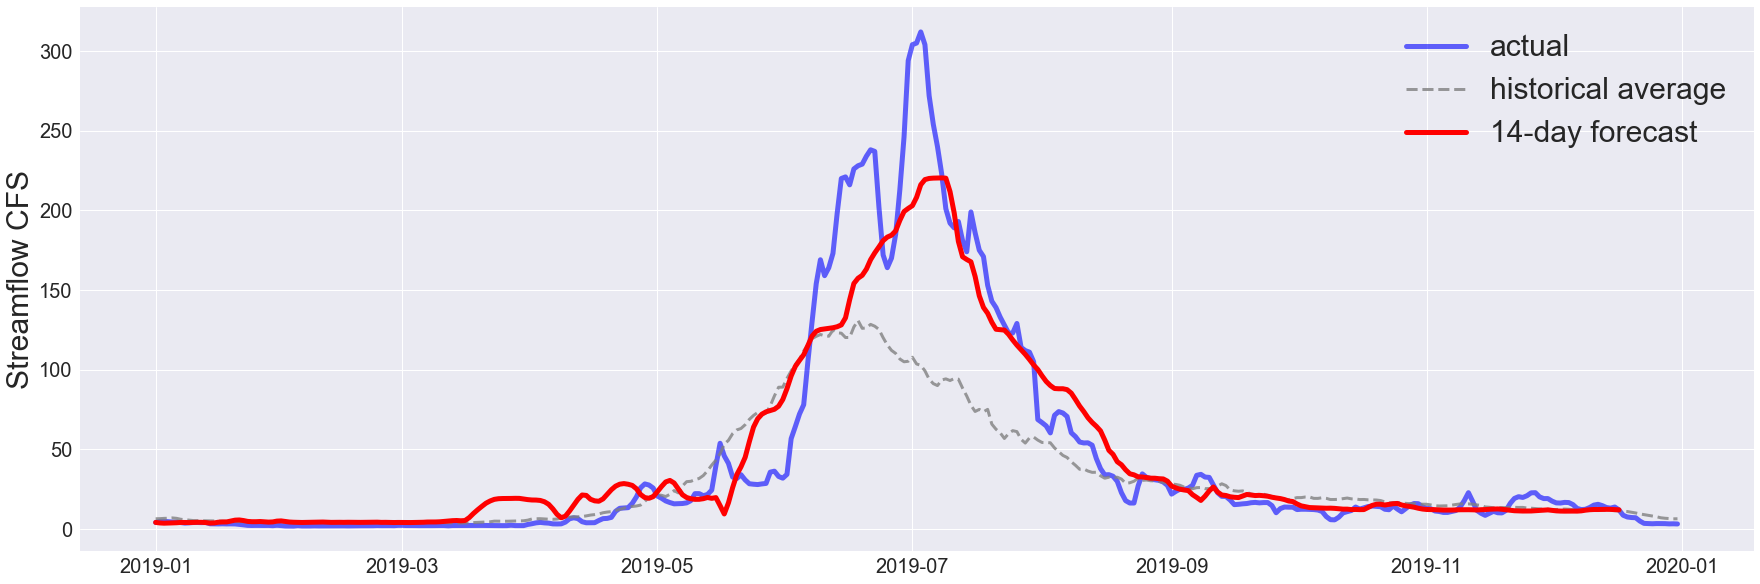

In [275]:
year_graph_lstm(lstm_v10, 'lstm_v10', '2019', df)

In [199]:
#functionize to take a year and produce graph showing actual, hist_avg, 1-day, 14-day, 30-day predictions. 
#function requires a minimum of 6000 samples, set pred_year accordingly
#function designed to work with project-specific column names, edits would be required to work with other data

def test_graph_lstm(model, model_name_string, pred_year, master_df):
    df = master_df.copy()
    
    #making desired year last year in sample data
    samp_df = df[:pred_year].copy()

    #trimming sample data to 6000 records total
    samp_df = samp_df.iloc[-6000:]

    # convert datetime column to continuous integer
    samp_df['ds'] = pd.to_datetime(df['ds']).sub(pd.Timestamp(df['ds'].iloc[0])).dt.days
    
    #don't pass in historical y to model
    samp_df.drop('hist_avg_y', axis=1, inplace=True)
    
    # scale entire dataframe except y column 
    scale_df = samp_df.copy()
    for column in scale_df.columns:
      if column != 'y':
        scaler = StandardScaler()
        # print (scale_df[column].values.shape)
        holder = scaler.fit_transform(scale_df[column].values.reshape(-1,1))
        scale_df[column] = holder.reshape(len(scale_df),)
        
    #test size depends if year is leap year or not
    test_size = 365
    if int(pred_year)%4 == 0:
        test_size = 366
        
    #these variables can't be changed without retraining models used in this project
    n_prev = 400 #model was trained on this input shape
    predict_steps = 30 #model was trained on this output shape
    
    #utilizes windowize_data function
    X, y = windowize_data(scale_df, n_prev, 'y', predict_steps)
    X_test = X[-test_size:]
    y_test = y[-test_size:]
    
    #use model to make predictions and make 0 the lower limit of predictions
    y_pred = model.predict(X_test)
    y_pred[y_pred<0] = 0
#     print(y_pred)

    
    #grab predictions at 1-day, 14-days, and 30-days out for each day of the year
    day_1_pred = y_pred[:,:1]
    day_14_pred = y_pred[:,13:14]
    day_30_pred = y_pred[:,-1:]
#     print(df[pred_year].index[30:])
  
# #######DO NOT DELETE########
# #     plot actual, hist_avg, and 1-day, 14-day, and 30-day predictions
#     plt.figure(figsize=(30,10))
#     plt.plot(df[pred_year].index, df[pred_year]['y'],label='actual', linewidth=5);
#     plt.plot(df[pred_year].index, df[pred_year]['hist_avg_y'],label='historical average', linewidth=3, color='green', alpha=0.8, linestyle='dashed')
#     plt.plot(df[pred_year].index[:-30], day_1_pred[30:], label='1-day forecast', linewidth=3, color='purple', alpha=0.3)
#     plt.plot(df[pred_year].index[:-14], day_14_pred[14:], label='14-day forecast', linewidth=5, color='red')
#     plt.plot(df[pred_year].index, day_30_pred, label='30-day forecast', linewidth=5, color='orange', alpha=0.4)
#     #formatting
#     plt.xticks(fontsize=20)
#     plt.yticks(fontsize=20)
#     plt.ylabel('Streamflow CFS', fontsize=30)
#     plt.legend(prop={"size":30})
# #     plt.savefig(f'graphs/{model_name_string}_yearly_{pred_year}.jpg')
#     plt.show()
# #########^^^^^^DO NOT DELETE^^^^^^#########


########DOESN'T THIS MAKE MORE SENSE FOR DATE RANGE OFFSETS??########
#     plot actual, hist_avg, and 1-day, 14-day, and 30-day predictions
    plt.figure(figsize=(30,10))
    plt.plot(df[pred_year].index, df[pred_year]['y'],label='actual', linewidth=5);
    plt.plot(df[pred_year].index, df[pred_year]['hist_avg_y'],label='historical average', linewidth=3, color='green', alpha=0.8, linestyle='dashed')
    plt.plot(df[pred_year].index[1:], day_1_pred[:-1], label='1-day forecast', linewidth=3, color='purple', alpha=0.3)
    plt.plot(df[pred_year].index[13:], day_14_pred[:-13], label='14-day forecast', linewidth=5, color='red')
    plt.plot(df[pred_year].index[30:], day_30_pred[:-30], label='30-day forecast', linewidth=5, color='orange', alpha=0.4)
    #formatting
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel('Streamflow CFS', fontsize=30)
    plt.legend(prop={"size":30})
#     plt.savefig(f'graphs/{model_name_string}_yearly_{pred_year}.jpg')
    plt.show()
##########^^^^^^DO NOT DELETE^^^^^^#########


    pass

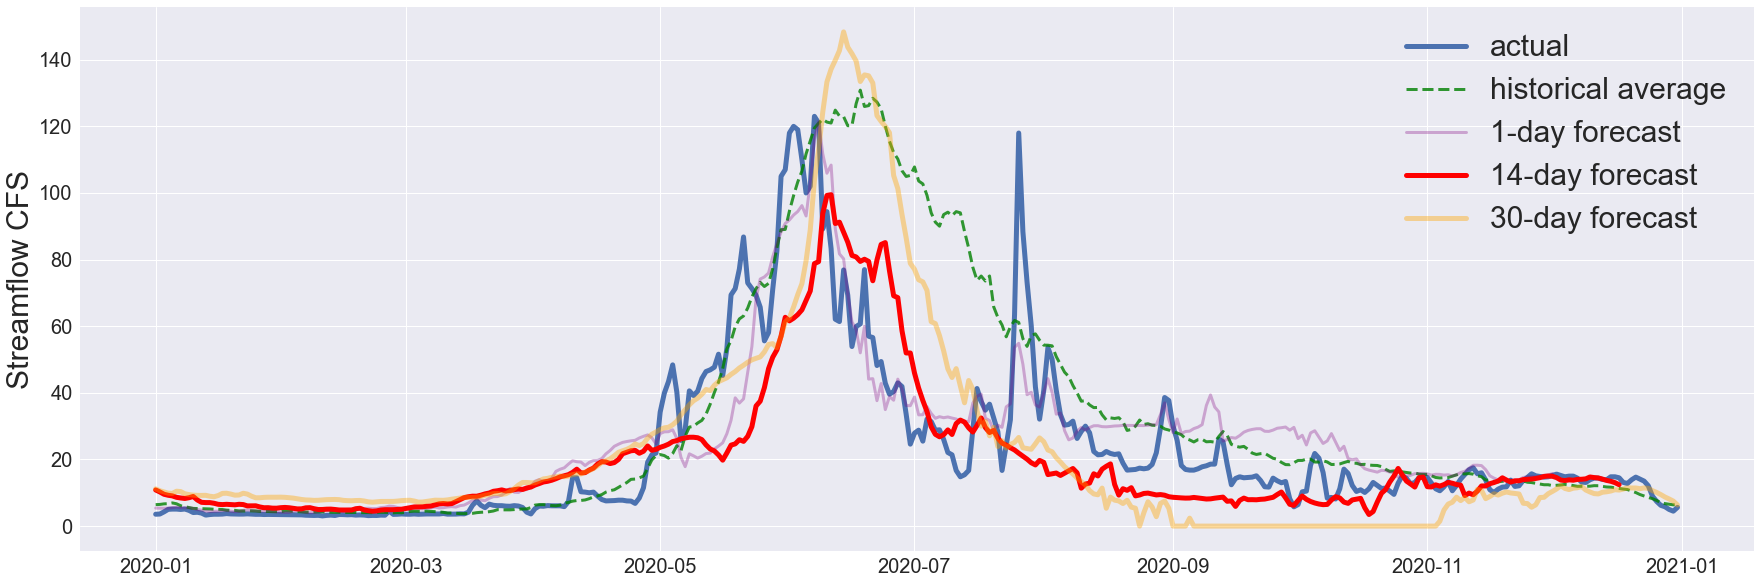

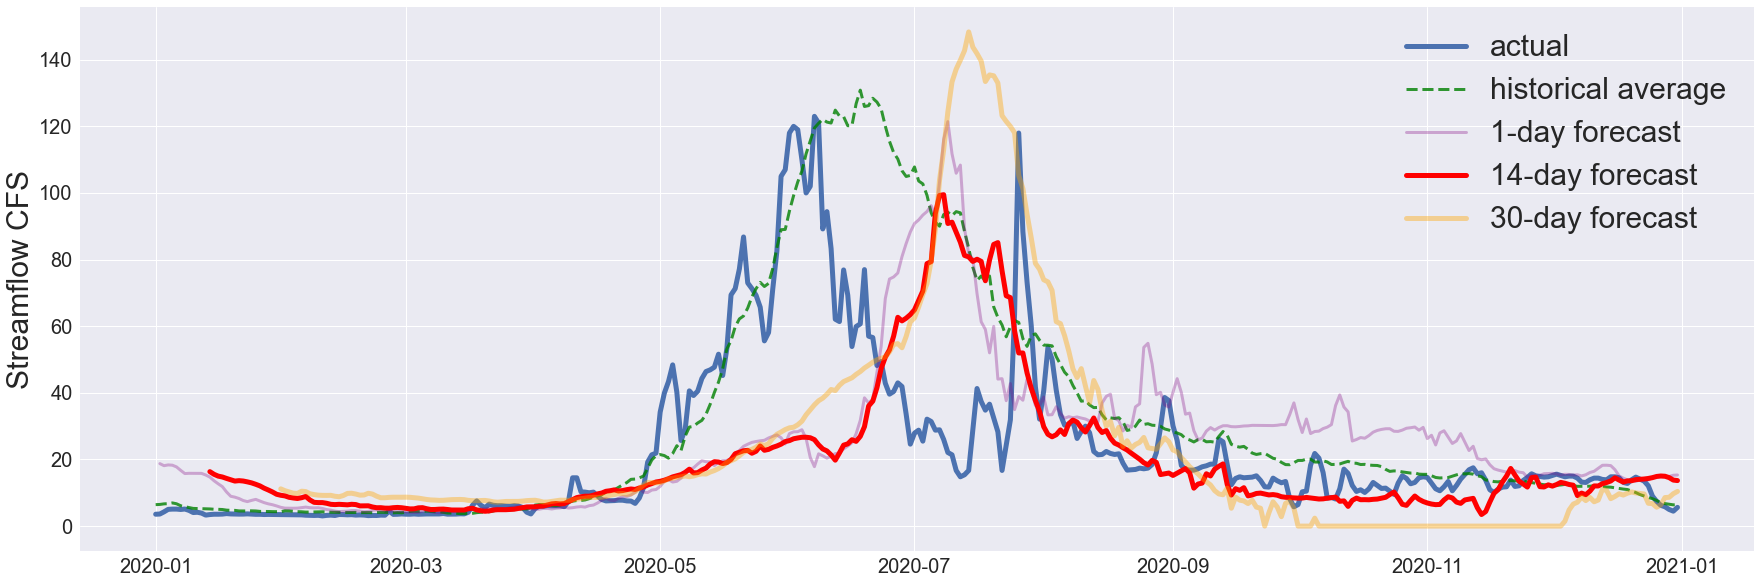

(None, None)

In [224]:
pass_year = '2020'
year_graph_lstm(lstm_v12, 'delme', pass_year, df), test_graph_lstm(lstm_v12, 'delme', pass_year, df)

In [276]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11323 entries, 1990-01-01 to 2020-12-31
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ds            11323 non-null  datetime64[ns]
 1   y             11323 non-null  float64       
 2   avg_temp      11323 non-null  float64       
 3   precip_accum  11323 non-null  float64       
 4   swe           11323 non-null  float64       
 5   hist_avg_y    11323 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 939.2 KB


In [277]:
df.head()

ds    y  avg_temp  precip_accum  swe  hist_avg_y
ds                                                                 
1990-01-01 1990-01-01  6.5      19.0           5.6  4.8    6.437742
1990-01-02 1990-01-02  6.9      16.0           5.7  4.8    6.502258
1990-01-03 1990-01-03  6.9       2.0           5.7  4.8    6.673226
1990-01-04 1990-01-04  6.8      -2.0           5.7  4.8    6.738387
1990-01-05 1990-01-05  7.3       1.0           5.7  4.8    6.955806

In [278]:
df.T

ds                     1990-01-01           1990-01-02           1990-01-03  \
ds            1990-01-01 00:00:00  1990-01-02 00:00:00  1990-01-03 00:00:00   
y                             6.5                  6.9                  6.9   
avg_temp                       19                   16                    2   
precip_accum                  5.6                  5.7                  5.7   
swe                           4.8                  4.8                  4.8   
hist_avg_y                6.43774              6.50226              6.67323   

ds                     1990-01-04           1990-01-05           1990-01-06  \
ds            1990-01-04 00:00:00  1990-01-05 00:00:00  1990-01-06 00:00:00   
y                             6.8                  7.3                    7   
avg_temp                       -2                    1                    9   
precip_accum                  5.7                  5.7                  5.7   
swe                           4.8                  4.8                  4.9   
hist_avg_y                6.73839              6.95581              6.69903   

ds                     1990-01-07           1990-01-08           1990-01-09  \
ds            1990-01-07 00:00:00  1990-01-08 00:00:00  1990-01-09 00:00:00   
y                             6.9                  7.2                  7.7   
avg_temp                       17                   22                   25   
precip_accum                  5.7                  5.7                  6.2   
swe                           4.9                  4.9                  5.3   
hist_avg_y                6.11032              5.82194              5.57774   

ds                     1990-01-10  ...           2020-12-22  \
ds            1990-01-10 00:00:00  ...  2020-12-22 00:00:00   
y                             7.3  ...                 14.1   
avg_temp                       30  ...                   24   
precip_accum                  6.2  ...                  4.5   
swe                           5.4  ...                  4.3   
hist_avg_y                5.30645  ...              9.47194   

ds                     2020-12-23           2020-12-24           2020-12-25  \
ds            2020-12-23 00:00:00  2020-12-24 00:00:00  2020-12-25 00:00:00   
y                            13.5                 12.1                 8.99   
avg_temp                       -1                    9                   22   
precip_accum                  4.6                  4.7                  4.8   
swe                           4.5                  4.6                  4.7   
hist_avg_y                9.03871              8.59903              8.22613   

ds                     2020-12-26           2020-12-27           2020-12-28  \
ds            2020-12-26 00:00:00  2020-12-27 00:00:00  2020-12-28 00:00:00   
y                            7.41                 6.23                  5.8   
avg_temp                       26                   13                   13   
precip_accum                  4.8                  4.9                    5   
swe                           4.7                  4.8                  4.9   
hist_avg_y                7.69774              7.05258              6.74871   

ds                     2020-12-29           2020-12-30           2020-12-31  
ds            2020-12-29 00:00:00  2020-12-30 00:00:00  2020-12-31 00:00:00  
y                            4.99                 4.48                 5.62  
avg_temp                        9                    6                   16  
precip_accum                  5.4                  5.4                  5.5  
swe                           5.3                  5.3                  5.4  
hist_avg_y                6.56742              6.37839              6.43774  

[6 rows x 11323 columns]

In [289]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11323 entries, 1990-01-01 to 2020-12-31
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ds            11323 non-null  datetime64[ns]
 1   y             11323 non-null  float64       
 2   avg_temp      11323 non-null  float64       
 3   precip_accum  11323 non-null  float64       
 4   swe           11323 non-null  float64       
 5   hist_avg_y    11323 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 939.2 KB


In [304]:
clipped = df['2020-04-25':'2020-05-25'].copy()

In [305]:
clipped.drop(columns=['ds','hist_avg_y'], axis=1, inplace=True)

In [306]:
clipped

y  avg_temp  precip_accum   swe
ds                                             
2020-04-25   6.81      32.0          19.4  19.6
2020-04-26   8.43      36.0          19.5  19.7
2020-04-27  11.50      40.0          19.5  19.7
2020-04-28  19.20      39.0          19.5  19.4
2020-04-29  21.40      44.0          19.5  19.2
2020-04-30  21.90      48.0          19.5  19.2
2020-05-01  34.20      48.0          19.5  19.1
2020-05-02  39.90      42.0          19.5  18.7
2020-05-03  43.40      45.0          19.5  18.2
2020-05-04  48.40      36.0          19.5  17.6
2020-05-05  40.20      35.0          19.5  17.7
2020-05-06  25.70      40.0          19.5  17.5
2020-05-07  29.00      37.0          19.5  17.1
2020-05-08  40.60      34.0          19.5  16.9
2020-05-09  39.20      36.0          19.5  16.5
2020-05-10  40.50      40.0          19.5  16.1
2020-05-11  44.30      36.0          19.5  15.6
2020-05-12  46.40      41.0          19.9  15.8
2020-05-13  46.90      42.0          19.9  15.6
2020-05-14  47.70      42.0          19.9  15.2
2020-05-15  51.60      40.0          19.9  14.6
2020-05-16  45.20      41.0          19.9  14.1
2020-05-17  53.30      47.0          19.9  13.4
2020-05-18  69.40      52.0          19.9  12.6
2020-05-19  71.30      49.0          19.9  11.8
2020-05-20  77.20      43.0          19.9  11.0
2020-05-21  86.80      38.0          19.9  10.4
2020-05-22  73.00      43.0          19.9   9.7
2020-05-23  71.30      42.0          19.9   8.8
2020-05-24  69.30      31.0          19.9   8.3
2020-05-25  65.70      31.0          20.5   8.9

In [307]:
clipped.columns = ['River Flow (cfs)', 'Avg Temp (F)', 'Accum Precip (in)', 'SWE (in)']

In [313]:
pd.options.display.max_columns = 6

In [314]:
clipped.T

ds                 2020-04-25  2020-04-26  2020-04-27  ...  2020-05-23  \
River Flow (cfs)         6.81        8.43        11.5  ...        71.3   
Avg Temp (F)            32.00       36.00        40.0  ...        42.0   
Accum Precip (in)       19.40       19.50        19.5  ...        19.9   
SWE (in)                19.60       19.70        19.7  ...         8.8   

ds                 2020-05-24  2020-05-25  
River Flow (cfs)         69.3        65.7  
Avg Temp (F)             31.0        31.0  
Accum Precip (in)        19.9        20.5  
SWE (in)                  8.3         8.9  

[4 rows x 31 columns]

In [316]:
clipped = clipped[['Accum Precip (in)', 'SWE (in)', 'Avg Temp (F)', 'River Flow (cfs)']]

In [317]:
clipped.T

ds                 2020-04-25  2020-04-26  2020-04-27  ...  2020-05-23  \
Accum Precip (in)       19.40       19.50        19.5  ...        19.9   
SWE (in)                19.60       19.70        19.7  ...         8.8   
Avg Temp (F)            32.00       36.00        40.0  ...        42.0   
River Flow (cfs)         6.81        8.43        11.5  ...        71.3   

ds                 2020-05-24  2020-05-25  
Accum Precip (in)        19.9        20.5  
SWE (in)                  8.3         8.9  
Avg Temp (F)             31.0        31.0  
River Flow (cfs)         69.3        65.7  

[4 rows x 31 columns]